In [779]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from time import time


# LQR classes

## Dynamics

In [780]:
class Dynamics:
    def __init__(self, state_dim, u_dim):
        self.state_dim = state_dim
        self.u_dim = u_dim
        
    def f(self,x,u):
        """
        x_{k+1} = self.f(x_k,u_k)
        """
        raise NotImplementedError 
    
    def df_dx(self, x, u):
        """
        Jacobian of f wrt x 
        """
        eps=1e-4
        
        Jac_x = np.zeros((self.state_dim, self.state_dim))
        for i in range(self.state_dim):
            x_h = x.copy().astype(float)
            x_h[i][0] += eps
            Jac_x[:,i] = (self.f(x_h,u) - self.f(x,u)).flatten()
        
        Jac_x /= eps
        return Jac_x
    
    def df_du(self, x, u):
        """
        Jacobian of f wrt u
        """
        eps=1e-4
        Jac_u = np.zeros((self.state_dim, self.u_dim))
        for i in range(self.u_dim):
            u_h = u.copy().astype(float)
            u_h[i][0] += eps
            Jac_u[:,i] = (self.f(x,u_h) - self.f(x,u)).flatten()
        Jac_u /= eps
        return Jac_u

    def test_df_dx(self, x, u):
        """
        Same as df_dx. But df_dx can be overriden. Jacobian of f wrt x 
        """
        eps=1e-4
        
        Jac_x = np.zeros((self.state_dim, self.state_dim))
        for i in range(self.state_dim):
            x_h = x.copy().astype(float)
            x_h[i][0] =  x_h[i][0] + eps
            Jac_x[:,i] = (self.f(x_h,u) - self.f(x,u)).flatten()
        Jac_x /= eps
        return Jac_x
    
    def test_df_du(self, x, u):
        """
        Jacobian of f wrt u
        """
        eps=1e-4
        Jac_u = np.zeros((self.state_dim, self.u_dim))
        for i in range(self.u_dim):
            u_h = u.copy().astype(float)
            u_h[i][0] += eps
            Jac_u[:,i] = (self.f(x,u_h) - self.f(x,u)).flatten()
        Jac_u /= eps
        return Jac_u

In [781]:
class LinearDynamics(Dynamics):
    def __init__(self, A, B):
        self.A = A
        self.B = B
        
        self.state_dim = self.A.shape[1]
        self.u_dim = self.B.shape[1]
        assert self.B.shape[0] == self.state_dim
    
    def f(self,x,u):
        return self.A.dot(x) + self.B.dot(u)
      
    def df_dx(self, x, u):
        return self.A
    
    def df_du(self, x, u):
        return self.B

In [782]:
def test_LinearDynamics():
    A = np.arange(9).reshape(3,3)
    B = np.arange(6).reshape(3,2)
    test = LinearDynamics(A=A,B=B)
    x = np.array([[2],
                 [-1],
                 [0]])
    u = np.array([[1],
                 [2]])
    assert np.sum(np.abs(test.f(x,u) - np.array([[1],[10],[19]]))) <= 1e-4
    assert np.sum(np.abs(test.df_dx(x,u) - test.test_df_dx(x,u))) <= 1e-4
    assert np.sum(np.abs(test.df_du(x,u) - test.test_df_du(x,u))) <= 1e-4
            
test_LinearDynamics()

## Cost

In [783]:
class Cost:
    def __init__(self, goal, N, u_goal):
        self.N = N
        self.goal = goal
        self.u_goal = u_goal
    
    def loss(self, x, u, k):
        raise NotImplementedError
    
    def l_x(self, x, k=None, u=None):
        raise NotImplementedError
    
    def l_u(self, u, k=None, x=None):
        raise NotImplementedError
    
    def l_xx(self, x=None, u=None, k=None):
        raise NotImplementedError
    
    def l_uu(self, x=None, u=None, k=None):
        raise NotImplementedError
    
    def l_xu(self, x=None, u=None, k=None):
        raise NotImplementedError
    
    def l_ux(self, x=None, u=None, k=None):
        raise NotImplementedError
    

In [784]:
class QuadraticCost(Cost):
    def __init__(self, dt, N, goal, Q, R, Qf=None, H=None, u_goal=None):
        super().__init__(goal=goal, N=N, u_goal=u_goal)
        self.dt = dt
        self._Q = Q
        self.R = R
        
        self.Qf = Qf
        if self.Qf is None:
            self.Qf = self.Q
        
        
        self.state_dim = self.Q.shape[0]
        self.u_dim = self.R.shape[0]
        
        self.H = H
        if self.H is None:
            self.H = np.zeros((self.state_dim, self.u_dim))
        if self.u_goal is None:
            self.u_goal = np.zeros((self.u_dim,1))
        
        
    @property
    def Q(self):
        return self._Q
    
    @Q.setter
    def Q(self, new_Q):
        assert new_Q.shape[0] == new_Q.shape[0] == self.goal.shape[0]
        self._Q = new_Q
    
    def loss(self, x, u, k):
        assert k <= self.N
        if k<self.N:
            assert u.shape == self.u_goal.shape, "u: "+str(u.shape) +", ugoal: " + str(self.u_goal.shape)
        if k == self.N:
            l = (1/2)*(x-self.goal).T.dot(self.Qf).dot(x-self.goal) 
            return float(l) #final cost: do not multiply by dt

        l = (1/2)*(x-self.goal).T.dot(self.Q).dot(x-self.goal) 
        l += (1/2)*(u-self.u_goal).T.dot(self.R).dot(u-self.u_goal)
        l += x.T.dot(self.H).dot(u) +  u.T.dot(self.H.T).dot(x)    
        return float(l)*self.dt
        
        
    def l_x(self, x,  u, k):
        """ 
        Derivative of loss wrt x (dl/dx)
        col vector size x_dim
        """
        assert k <= self.N
        assert x.shape[0] == self.state_dim
        if k == self.N:
            lx = self.Qf.dot(x-self.goal)
            return lx

        lx = self.Q.dot(x - self.goal)
        lx += self.H.dot(u)

        assert lx.shape[1] == 1
        assert lx.shape[0] == self.state_dim
        
        return lx*self.dt
    
    
    def l_u(self, x, u, k):
        """ column vector size u_dim """
        assert k < self.N
        assert u.shape[0] == self.u_dim
        lu = self.R.dot(u - self.u_goal)
        lu += self.H.T.dot(x)
            
        assert lu.shape[1] == 1
        assert lu.shape[0] == self.u_dim
        return lu*self.dt
    
    def l_xx(self, x, u, k):
        if k == self.N:
            return self.Qf
        lxx = self.Q
        return lxx*self.dt
    
    def l_uu(self, x, u, k):
        assert k < self.N
        return self.R*self.dt
    
    def l_xu(self, x, u, k):
        assert k < self.N
        return self.H*self.dt
    
    def l_ux(self, x, u, k):
        assert k < self.N
        return self.H.T*self.dt

In [785]:
# TEST
def test_QuadraticCost():
    dt = 0.01
    N = 100
    x = np.array([[2],[-1],[0]])
    xf = np.array([[1],[0],[1]])

    u = np.array([[2],[1]])

    Q = 2*np.eye(3)
    R = np.eye(2)
    Qf = 10*np.eye(3)
    H = None
    u_goal = None



    q = QuadraticCost(dt=dt, N=N,
                      goal=xf,
                      Q=Q, R=R, Qf=Qf, H=H, u_goal=u_goal)
    k = np.random.randint(N)
    assert q.loss(x=x,u=u,k=k) == 11*dt/2
    assert q.loss(x=x,u=u,k=N) == 15, q.loss(x=x,u=u,k=N) 
    
    dl_dx = np.array([[2],[-2],[-2]])*dt
    assert (q.l_x(x=x,u=u,k=k) - dl_dx).all() <= 1e-3
    assert (q.l_xx(x=x,u=u,k=k) - Q).all() <= 1e-3
    assert (q.l_u(x=x,u=u,k=k) - u*dt).all() <= 1e-3
    assert (q.l_uu(x=x,u=u,k=k) - R).all() <= 1e-3
    
    assert (np.sum(np.abs(q.l_ux(x=x,u=u,k=k))) == 0)
    assert (np.sum(np.abs(q.l_xu(x=x,u=u,k=k))) == 0)
    
    
    # Same cost when tf is same
    c = 0
    for i in range(N+1):
        c += q.loss(x,u,i)


    dt = 0.1
    N = 10

    q2 = QuadraticCost(dt=dt, N=N,
                      goal=xf,
                      Q=Q, R=R, Qf=Qf, H=H, u_goal=u_goal)

    d = 0
    for i in range(N+1):
        d += q2.loss(x,u,i)

    assert np.abs(c - d) <= 1e-2 , str(c) + " " +str(d)
test_QuadraticCost()

## Problem

In [129]:
class Problem:
    def __init__(self, 
                 dynamics, 
                 cost,
                 dt,
                 x0,
                 ):
        self.N = cost.N
        self.dt = cost.dt
        self.tf = N*dt
        
        self.dyn = dynamics
        self.cost = cost
        self.x0 = x0
        
        assert self.x0.shape[0] == self.dyn.state_dim
        assert self.x0.shape[1] == 1
        
        
        if "state_dim" in self.cost.__dict__:
            assert self.dyn.u_dim == self.cost.u_dim
            assert self.dyn.state_dim == self.cost.state_dim

## Solver

In [130]:
class Solver:
    def __init__(self, problem):
        self.LP = problem
        self.solved = False
        self.x = [None for i in range(self.LP.N + 1)] #(x_0,... , x_N-1, x_N)
        self.u = [None for i in range(self.LP.N)] # (u_0, ..., u_N-1)
        self.J = [None for i in range(self.LP.N + 1)] # Cum loss (J_0, ..., J_N)
    
    def plot_loss(self):
        if self.solved:
            plt.plot(self.J, label="Cum loss")
            plt.title("Loss wrt iterations")
            plt.grid()
            plt.legend()
        else:
            "Solve first"
    
    def plot_u(self):
        if not self.solved:
            "Solve first"
        else:
            u_dim = self.LP.dyn.u_dim
            for i in range(u_dim):
                if u_dim == 1:
                    u_i = [float(self.u[t]) for t in range(self.LP.N)]
                    plt.plot(u_i, label=f"u")
                else:
                    u_i = [float(self.u[t][i]) for t in range(self.LP.N)]
                    
                    plt.plot(u_i, label=f"u_{i}")
                plt.legend()
            plt.grid()
            plt.title("Control u wrt iterations")
            
    def plot_x(self, idx=None):
        if not self.solved:
            "Solve first"
        else:
            xf = self.LP.cost.goal
            x_dim = self.LP.dyn.state_dim
            if idx is None:
                idx = np.arange(x_dim)
            for i in range(x_dim):
                if x_dim == 1:
                    plt.plot(self.x, label=f"x")
                    plt.plot(xf*np.ones(self.LP.N+1), "k--", label=f'xf at N')
                else:
                    if i in idx:
                        plt.plot(xf[i]*np.ones(self.LP.N+1), "k--")#, label=f'xf_{i} at N')
                        x_i = [self.x[t][i] for t in range(self.LP.N+1)]
                        plt.plot(x_i, label=f"x_{i}")
                plt.legend()
            plt.grid()
            plt.title(f"x, goal:{self.LP.cost.goal}")
    

### LQR

In [131]:
class LQR(Solver):
    def __init__(self, LinearProblem):
        super().__init__(LinearProblem)
    
    def init(self):
        self.J_star = [None for i in range(self.LP.N + 1)]
        
        self.V = [None for i in range(self.LP.N + 1)]
        self.W = [None for i in range(self.LP.N + 1)]
        
        
        self.H = [self.LP.cost.hess_l1(self.goal(i), i) for i in range(self.LP.N + 1)]
        self.G = [self.LP.cost.grad_l1(self.goal(i), i) for i in range(self.LP.N + 1)]

        self.L = [None for i in range(self.LP.N)]
        
    
    def goal(self, n):
        if self.LP.cost.unique_goal:
            return self.LP.cost.goal
        return self.LP.cost.goal[n]
        
    def backward(self):
        N = self.LP.N
        R = self.LP.cost.R
        A = self.LP.dyn.A
        B = self.LP.dyn.B
        
        self.V[N] = (1/2) * self.H[N]
        self.W[N] = self.G[N] - self.H[N].dot(self.goal(N))
        
        
        for i in range(self.LP.N, 0, -1):
            tmp = A.T.dot(self.V[i]).dot(B)
            tmp2 = np.linalg.inv(R+B.T.dot(self.V[i]).dot(B))
            self.V[i-1] = .5 * self.H[i-1] - tmp.dot(tmp2).dot(tmp.T) + A.T.dot(self.V[i]).dot(A)
            
            self.W[i-1] = self.G[i-1] - self.H[i-1].T.dot(self.goal(i-1)) + A.T.dot(self.W[i]) \
            - tmp.dot(tmp2).dot(B.T.dot(self.W[i]))
            
    def forward(self):
        """
        Compute lqr controls u, states x, J_star        
        """
        R = self.LP.cost.R
        A = self.LP.dyn.A
        B = self.LP.dyn.B
        
        x = self.LP.x0
        self.x[0] = x
        for i in range(self.LP.N):
            u = - np.linalg.inv(R+B.T.dot(self.V[i+1]).dot(B)).dot(.5*B.T.dot(self.W[i+1]) \
                                                           + B.T.dot(self.V[i+1]).dot(A).dot(x))
            if self.LP.dyn.u_dim == 1:
                self.u[i] = float(u)
            else:
                self.u[i] = u                
            self.J_star[i] = float(x.T.dot(self.V[i]).dot(x) + self.W[i].T.dot(x)) #up to constant
            
            if i == 0:
                self.J[i] =  self.LP.cost.loss(x, u, i)
            else:
                self.J[i] = self.J[i-1] + self.LP.cost.loss(x, u, i)
            x = self.LP.dyn.next_state(x, u)
            self.x[i+1] = x
            
        self.J[self.LP.N] = self.J[self.LP.N-1] + self.LP.cost.loss(x, 0, self.LP.N)
            
        self.J_star[self.LP.N] = float(x.T.dot(self.V[self.LP.N]).dot(x) \
                                       + self.W[self.LP.N].T.dot(x)) #up to constant
            
    def solve(self):
        self.init()
        self.backward()
        self.forward()
        self.solved = True
        print("Last Loss: ", self.J_star[-1])
    


### iLQR 

In [1008]:
class iLQR(Solver):
    def __init__(self,
                 problem,
                 n_traj,
                 u_init,
                 alpha_init=1,
                 crit_alpha=1e-1,
                rho_reg=0,
                beta=[1e-4,10],
                gamma=.5,
                alpha_min=1e-3):
        """
        n_traj (int) : number of trajectories
        u_init (list[float]) : sequence of controls (N elements)
        
        """
        
        super().__init__(problem)
        self.n_traj = n_traj
        self.u_init = u_init
        
        
        self.rho_reg = rho_reg
        
        # Line search param
        self.alpha_init = alpha_init
        self.alpha = alpha_init
        self.crit_alpha = crit_alpha
        self.alpha_min = alpha_min
        
        self.gamma = gamma
        self.beta = beta
        assert len(self.u_init) == self.LP.N
        assert self.u_init[0].shape[1] == 1
        assert self.u_init[0].shape[0] == self.LP.dyn.u_dim
    
    def reset(self):
        #self.V = [None for i in range(self.LP.N + 1)] # "S_k"
        #self.w = [None for i in range(self.LP.N + 1)] # "s_k"
        
        self.K = [None for i in range(self.LP.N)] # (K_0, ..., K_N-1) for each u_k
        self.d = [None for i in range(self.LP.N)]
        self.cond_nb = []
        self.expected_cost = [None for i in range(self.LP.N)]
        self.J = [None for i in range(self.LP.N+1)]
        #self.du = [None for i in range(self.LP.N)]
        #self.dx =  [None for i in range(self.LP.N +1)]
        #self.dx[0] = np.zeros_like(self.LP.x0)
        
    def backward(self):
        #self.reset()
        
        #self.w[self.LP.N] = self.LP.cost.l_x(x=self.x[self.LP.N],u=None, k=self.LP.N)
        #self.V[self.LP.N] = self.LP.cost.l_xx(x=self.x[self.LP.N],u=None, k=self.LP.N)
        w = self.LP.cost.l_x(x=self.x[self.LP.N],u=None, k=self.LP.N)
        V = self.LP.cost.l_xx(x=self.x[self.LP.N],u=None, k=self.LP.N)
        assert np.abs(V - self.LP.cost.Qf).all() <= 1e-3
        assert np.abs(self.LP.cost.Qf.dot(self.x[self.LP.N] \
                                          - self.LP.cost.goal) \
                      - w).all() <= 1e-3, str(w) + " " + str(self.LP.cost.Qf.dot(self.x[self.LP.N] \
                                          - self.LP.cost.goal))
                
                
        for k in range(self.LP.N-1, -1, -1):
            A = self.LP.dyn.df_dx(x=self.x[k],u=self.u[k])
            B = self.LP.dyn.df_du(x=self.x[k],u=self.u[k])
            
            Qx = self.LP.cost.l_x(x=self.x[k], u=self.u[k],k=k) + A.T.dot(w)#A.T.dot(self.w[k+1])
            assert Qx.shape[0] == self.LP.dyn.state_dim
            Qu = self.LP.cost.l_u(x=self.x[k], u=self.u[k],k=k) + B.T.dot(w)#B.T.dot(self.w[k+1])
            assert Qu.shape[0] == self.LP.dyn.u_dim 
            assert Qx.shape[1] == Qu.shape[1] == 1
            
            Qux = self.LP.cost.l_ux(x=self.x[k], u=self.u[k],k=k) + B.T.dot(V).dot(A)#B.T.dot(self.V[k+1]).dot(A)
            assert Qux.shape[0] == self.LP.dyn.u_dim
            assert Qux.shape[1] == self.LP.dyn.state_dim
            
            Qxu = Qux.T
            Qxx = self.LP.cost.l_xx(x=self.x[k], u=self.u[k],k=k) + A.T.dot(V).dot(A)#A.T.dot(self.V[k+1]).dot(A)
            Quu = self.LP.cost.l_uu(x=self.x[k], u=self.u[k],k=k) + B.T.dot(V).dot(B)#B.T.dot(self.V[k+1]).dot(B)
            Quu += self.rho_reg*np.eye(Quu.shape[0])
            assert Quu.shape[0] == Quu.shape[1] == self.LP.dyn.u_dim
            assert Qxx.shape[0] == Qxx.shape[1] == self.LP.dyn.state_dim
            
            Quu_inv = np.linalg.inv(Quu)
            
            
            cond_nb_Quu = np.linalg.cond(Quu)
            
            
            self.K[k] = - Quu_inv.dot(Qux)
            assert self.K[k].shape[0] == self.LP.dyn.u_dim
            assert self.K[k].shape[1] == self.LP.dyn.state_dim
            self.d[k] = - Quu_inv.dot(Qu)
            assert self.d[k].shape[1] == 1
            assert self.d[k].shape[0] == self.LP.dyn.u_dim
            
            self.expected_cost[k] = [self.d[k].T.dot(Qu), 
                                     .5* self.d[k].T.dot(Quu).dot(self.d[k])]
            
            w = Qx + self.K[k].T.dot(Qu) + (self.K[k].T.dot(Quu) + Qxu).dot(self.d[k])
            V = Qxx + self.K[k].T.dot(Quu).dot(self.K[k]) + Qxu.dot(self.K[k]) + self.K[k].T.dot(Qux)
            #self.w[k] = Qx + self.K[k].T.dot(Qu) + (self.K[k].T.dot(Quu) + Qxu).dot(self.d[k])
            #self.V[k] = Qxx + self.K[k].T.dot(Quu).dot(self.K[k]) + Qxu.dot(self.K[k]) + self.K[k].T.dot(Qux)
            #assert self.w[k].shape[0] == self.V[k].shape[0] == self.V[k].shape[1] == self.LP.dyn.state_dim
            #assert self.w[k].shape[1] == 1
       
    def forward(self, init=False):
        
        if init: # First rollout
            self.u = self.u_init.copy()
            self.x[0] = self.LP.x0
            self.J[0] = self.LP.cost.loss(self.x[0], self.u[0],k=0)
            for k in range(self.LP.N):               
                self.x[k+1] = self.LP.dyn.f(self.x[k], self.u[k])
                if k == self.LP.N-1:
                    self.J[self.LP.N] = self.J[k] + self.LP.cost.loss(self.x[k+1], 
                                                            u=None,
                                                            k=k+1)
                else:
                    self.J[k+1] = self.J[k] + self.LP.cost.loss(self.x[k+1], 
                                                            self.u[k+1],
                                                            k=k+1)
                
            self.init_rollout = self.x
                
        # si traj_{k+1}- trak{k} > 1: alpha/=2
        #zk+1-zk > c 10-2 alpha/=2, alpha = 10, alpha =1
        
        else:
            counter = 0
            alpha_ok = False
            Delta_V = 0
            while not alpha_ok :
                counter += 1
                if counter == 2000: assert 1==0
                    
                candidate_u = self.u.copy()
                candidate_x = self.x.copy()
                candidate_J = [None for i in range(self.LP.N+1)]
                
                dx =  np.zeros((self.LP.dyn.state_dim, 1))
                alpha_ok = True
                for k in range(self.LP.N):
                    du = self.alpha*self.d[k] + self.K[k].dot(dx) #delta u_k
                    
                    dx_2 = (self.LP.dyn.df_dx(candidate_x[k], candidate_u[k]).dot(dx) + \
                            self.LP.dyn.df_du(candidate_x[k], candidate_u[k]).dot(du)) # Pour tester, = delta x_{k+1}
                    
                    candidate_u[k] = candidate_u[k] + du #u_k^t = u_k^{t-1} + delta u_k
                    candidate_x[k] = candidate_x[k] + dx #x_k^t = x_k^{t-1} + delta x_k
                    next_x = self.LP.dyn.f(candidate_x[k], candidate_u[k]) #x_{k+1}^t
                    
                    dx = next_x - candidate_x[k+1] # delta x_{k+1} = x_{k+1}^t - x_{k+1}^{t-1}
                    
                    diff_dx = np.abs(dx-dx_2).flatten()
                    
                    
                    
                    if k == 0:
                        candidate_J[0] = self.LP.cost.loss(candidate_x[k], candidate_u[k],k=k)
                    else:
                        candidate_J[k] = candidate_J[k-1] + self.LP.cost.loss(candidate_x[k], candidate_u[k],k=k)
                    
                    
                    if np.max(diff_dx) >= self.crit_alpha:
                        print(f"k = {k}, alpha = {self.alpha}")
                        print(f"dx = {dx.flatten()}, \n should be equal to \n {dx_2.flatten()} \n")
                    
                    
                    
                    #print(f"dx={dx}, du={du}")
                   # if (np.linalg.norm(dx)/(np.linalg.norm(next_x)+1) >= self.crit_alpha \
                    #    and np.linalg.norm(du)/(np.linalg.norm(tmp_u[k])+1) >= self.crit_alpha \
                     #  and self.alpha >= 1e-3):
                    
                    #if (np.abs(dx) > self.crit_alpha).any() or (np.abs(du) > self.crit_alpha).any():
                    #Delta_V += (self.alpha*self.expected_cost[k][0] + \
                     #           self.alpha**2 * self.expected_cost[k][1])
                  
                    #if ( self.alpha > self.alpha_min and \
                     #   (self.beta[0] >= np.abs((candidate_J[k] - self.J[k])/ Delta_V) or \
                      #  np.abs((candidate_J[k] - self.J[k])/ Delta_V) >= self.beta[1])) :
                        self.alpha = self.gamma*self.alpha
                        alpha_ok = False
                        break
                    
                    
                if alpha_ok:
                    
                    candidate_x[self.LP.N] = candidate_x[self.LP.N] + dx
                    candidate_J[self.LP.N] = candidate_J[self.LP.N-1] + self.LP.cost.loss(candidate_x[self.LP.N],
                                                                                          u=None,
                                                                                          k=self.LP.N)
                    
                    self.x = candidate_x.copy()
                    self.u = candidate_u.copy()
                    self.J = candidate_J
                    #self.alpha = self.alpha_init

    
        
    def compute_loss(self):
        self.J[0] = self.LP.cost.loss(self.x[0], self.u[0],k=0)
        
        for k in range(1,self.LP.N):
            self.J[k] = self.J[k-1] + self.LP.cost.loss(self.x[k], self.u[k],k=k)
        self.J[self.LP.N] = self.J[self.LP.N-1] + self.LP.cost.loss(self.x[self.LP.N], 0,k=self.LP.N)
        
    def solve(self, ):
        self.reset()
        self.rollout_hist = []
        self.all_cond_nb = []
        
        self.forward(init=True)
        
        for i_traj in range(self.n_traj):
            if i_traj%3 == 0:
                self.rollout_hist.append(self.x)
            if i_traj%10==0:
                print(f'**** {i_traj}-th Trajectory ' )
                
            self.backward()
            self.forward()
            
            self.all_cond_nb.append(self.cond_nb)
           
         
        self.compute_loss()
        self.solved = True
        print("Last Loss: ", self.J[-1])
    


# Problems

In [885]:
class Environment:
    def __init__(self, dt, state_dim, u_dim):
        self.dt = dt
        
        self.state_dim = state_dim
        self.u_dim = u_dim
        
        self.dynamics = None


    def create_problem(self,
                       x0,
                       xf,
                       N,
                       Q=None,
                       R=None,
                       Qf=None,
                      scale=1):
        scale = scale
        if Q is None:
            Q = scale*np.eye(self.state_dim)
        if R is None:
            R = scale*np.eye(self.u_dim)
        cost = QuadraticCost(Q=Q,
                             R=R,
                             Qf=Qf,
                             goal=xf,
                             N=N,
                             dt=self.dt,
                            )
        print("Initial cost: x0, u= 0, J = ", cost.loss(x=x0,u=np.zeros((self.u_dim,1)),k=0))
        print("Last cost: x0, u= 0, J = ", cost.loss(x=x0,u=np.zeros((self.u_dim,1)),k=N))
        return Problem(dynamics=self.dynamics,
                         cost=cost,
                         dt=self.dt,
                         x0=x0
                        )
    
    def solve_iLQR(self, 
                   x0,
                   xf,
                   N,
                   n_traj,
                   alpha_init,
                   crit_alpha,
                   Q=None,
                   R=None,
                   Qf=None,
                   scale_Q=1
                  ):
        """
        solve with iLQR:
        - initialize with random uniform * 1e-3
        - Q, R = eye
        """
        problem = self.create_problem(x0=x0,
                                      xf=xf,
                                      N=N,
                                     Q=Q,
                                     R=R,
                                     Qf=Qf,
                                     scale=scale_Q)
        self.ilqr = iLQR(problem=problem,
                           n_traj=n_traj,
                           u_init=[(1e-3)*np.random.uniform(size=(self.u_dim,1)) for i in range(N)],
                        alpha_init=alpha_init,
                        crit_alpha=crit_alpha)
        self.ilqr.solve()
    
    def position(self,x):
        raise NotImplementedError
        
        
    def create_animation(self, name="animation", x=None):
        if x is None:
            assert self.ilqr.solved, "solve first"
            solver_ilqr = True
            N = self.ilqr.LP.N
            x = self.ilqr.x
            x0 = self.ilqr.LP.x0
        else:
            N = len(x)
            x0 = x[0]
            solver_ilqr = False
            
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                             xlim=(-7, 7), ylim=(-5, 5))
        
        ax.grid()
        
        if solver_ilqr:
            line_goal, = ax.plot([], [], 'ko-', lw=2, label="goal")
            line_goal.set_data(*self.position(self.ilqr.LP.cost.goal))
        
        line_init, = ax.plot([], [], 'mo-', lw=2, label="initial")
        line_init.set_data(*self.position(x0))
        
        line, = ax.plot([], [], 'ro-', lw=2)
        
        ax.legend()
        def init():
            line.set_data([], [])
            return line, 
        
        def animate(t):
            line.set_data(*self.position(x[t]))
            return line,
        
        animate(0)

        ani = animation.FuncAnimation(fig, animate, frames=N, init_func=init)
        ani.save(name+'.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


            

## Mass moving horizontally

In [1027]:
class HorizontalMassEnv(Environment):
    def __init__(self, dt,m):
        super().__init__(dt, state_dim=2, u_dim=1)
        self.m = m #mass
        
        
        A = np.array([[1,self.dt],[0,1]])
        B = np.array([[0],[self.dt/self.m]])
        self.dynamics = LinearDynamics(A,B)
        
    def position(self,x):
        position_x = [x[0][0]]
        position_y = [0]
        return (position_x, position_y)

In [1028]:
m = 1 
dt = 0.1

HM_env = HorizontalMassEnv(m=m, dt=dt)

N = 200
x0 = np.array([[5],[-10]])
xf = np.array([[0],[0]])
print(x0, "x0")
print(xf, "xf")


[[  5]
 [-10]] x0
[[0]
 [0]] xf


In [1029]:
HM_env.solve_iLQR(x0=x0,
                  xf=xf,
                  N=N,
                  n_traj=10,
                 alpha_init=1,
                 crit_alpha=10)

Initial cost: x0, u= 0, J =  6.25
Last cost: x0, u= 0, J =  62.5
**** 0-th Trajectory 
Last Loss:  62.959465276393004


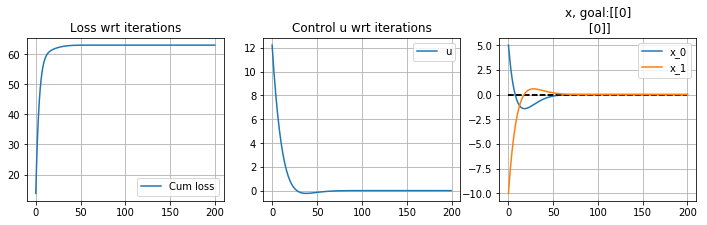

In [1030]:

plt.figure(figsize=(12,3))
plt.subplot(131)
HM_env.ilqr.plot_loss()
plt.subplot(132)
HM_env.ilqr.plot_u()
plt.subplot(133)
HM_env.ilqr.plot_x()

In [838]:
HM_env.create_animation(name="HM")

AssertionError: solve first

## Mass moving on table

In [1031]:
class TableMassEnv(Environment):
    """
    state = (x,x_dot,y,y_dot)
    """
    def __init__(self, dt, m):
        super().__init__(dt, state_dim=4, u_dim=2)
        
        self.m = m
        
        A = np.eye(self.state_dim)
        A[0,1], A[2,-1] = self.dt, self.dt

        B = np.zeros((self.state_dim, self.u_dim))
        B[1,0], B[3,1] = self.dt, self.dt
        
        self.dynamics = LinearDynamics(A,B)
        
    def position(self,x):
        position_x = [x[0][0]]
        position_y = [x[2][0]]
        return (position_x, position_y)

In [1032]:
dt = 0.1
N = 100
m = 1 

x0 = np.array([[4], #x
               [5], #x_dot
               [4], #y
               [0]])#y_dot
xf = np.array([[0], #x
               [0], #x_dot
               [0], #y
               [0]])#y_dot
print(x0, "x0")
print(xf, "xf")


TM_env = TableMassEnv(dt=dt, m=m)

[[4]
 [5]
 [4]
 [0]] x0
[[0]
 [0]
 [0]
 [0]] xf


Initial cost: x0, u= 0, J =  2.85
Last cost: x0, u= 0, J =  28.5
**** 0-th Trajectory 
Last Loss:  74.85345923189531


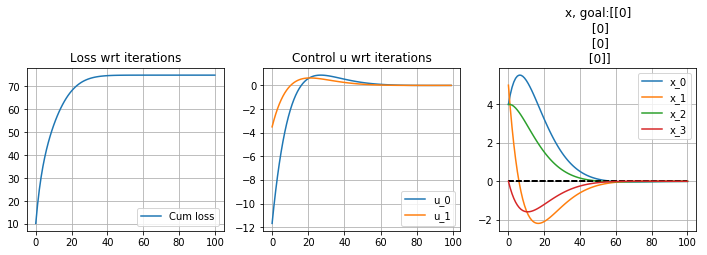

In [1033]:
TM_env.solve_iLQR(x0=x0,
                  xf=xf,
                  N=N,
                  n_traj=1,
                alpha_init=1,
                 crit_alpha=100)


plt.figure(figsize=(12,3))
plt.subplot(131)
TM_env.ilqr.plot_loss()
plt.subplot(132)
TM_env.ilqr.plot_u()
plt.subplot(133)
TM_env.ilqr.plot_x()

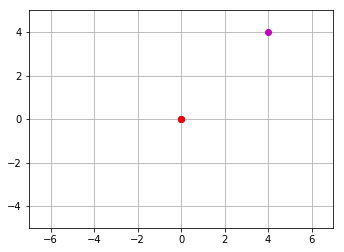

In [1296]:
TM_env.create_animation(name="TM")

## Cartpole

Dynamics :
\begin{align*}
\ddot x &= \frac{F + m\sin \theta (g \cos \theta + \ell \dot \theta^2)}{M + m \sin^2 \theta} \\
\ddot \theta &= \frac{-(M+m)g \sin \theta - m \ell \dot \theta^2 \cos \theta \sin \theta - F \cos \theta}{\ell (M + m \sin^2 \theta)}
\end{align*}

Let  $q = (x,  \theta, \dot x, \dot \theta)^T$, $u = F$.  

$\dot q = f(q,u) = 
\begin {bmatrix}
\dot x\\
\dot \theta\\
\frac{F + m\sin \theta (g \cos \theta + \ell \dot \theta^2)}{M + m \sin^2 \theta} \\
\frac{-(M+m)g \sin \theta - m \ell \dot \theta^2 \cos \theta \sin \theta - F \cos \theta}{\ell (M + m \sin^2 \theta)}
\end{bmatrix}$ 

$u_0 = 0$, $q_0 = (0,\pi,0,0)^T$ is a fixed point:  $f(q_0,u_0) = \dot q_0= 0$

Denote by $\bar{q} = q-q_0$, $\bar{u} = u-u_0$. Linearizing around $q_0,u_0$ yields

\begin{align*}
\dot q   = f(q,u) &\approx f(q_0,u_0) + \frac{\partial f}{\partial q}_{|q = q_0, u = u_0} (q-q_0) + \frac{\partial f}{\partial u}_{|q=q_0, u = u_0} (u-u_0) \\
\dot q = \dot{ \bar{q}} &\approx
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1\\
0 & \frac{mg}{M} & 0 & 0 \\
0 & \frac{(m+M)g}{\ell M} & 0 & 0 
\end{bmatrix}\bar{q} +
\begin{bmatrix}
0  \\
0\\
 \frac{1}{M} \\
 \frac{1}{\ell M}  
\end{bmatrix}\bar{u}
\end{align*}

In [1034]:
class CartPoleDynamics(Dynamics):
    def __init__(self, dt, m, M, l):
        """
        dt: discretization step
        """
        self.dt = dt
        self.m = m
        self.M = M
        self.l = l
        self.g = 9.81
        
        super().__init__(state_dim=4, u_dim=1)
        
    
    
    def f(self, x, u):
        """
        if we denote g by x_dot(t) = g(x(t),u(t))
        Then x_{k+1} = x_k + g(x_k, u_k)dt = f(x_k,u_k)
        """
        u = u[0][0]
        cth = np.cos(x[1][0])
        sth = np.sin(x[1][0])
        theta_dot = x[3][0]
        
        dxdt = np.zeros((self.state_dim, 1))
        dxdt[0][0] = x[2][0] #x_dot
        dxdt[1][0] = theta_dot

        tmp_div = self.M + self.m*sth**2

        dxdt[2][0] =  (u + self.m*sth*(self.g*cth + self.l*theta_dot**2)) / tmp_div
        dxdt[3][0] = (-(self.m+self.M) * self.g * sth \
                      - self.m*self.l*theta_dot**2*cth*sth \
                      - u*cth )/ (self.l*tmp_div)
        return x + dxdt*self.dt
    
    def mdf_du(self,x,u):
        cth = np.cos(x[1][0])
        sth = np.sin(x[1][0])
        tmp_div = self.M + self.m*sth**2
        Jac_u = np.zeros((self.state_dim, self.u_dim))
        Jac_u[2][0] = 1/tmp_div
        Jac_u[3][0] = -cth/(self.l*tmp_div)
        return Jac_u*self.dt
    
    def mdf_dx(self, x,u):
        u = float(u)
        cth = np.cos(x[1][0])
        sth = np.sin(x[1][0])
        theta_dot = x[3][0]
        Jac_x = np.eye((self.state_dim))
        tmp_div = self.M + self.m*sth**2
        
        Jac_x[0][2] += self.dt
        Jac_x[1][3] += self.dt
        Jac_x[2][1] += (self.m*self.dt/tmp_div**2) * (self.g*(self.M - (self.m+2*self.M)*sth**2)\
                                                      + self.l*theta_dot**2*cth*(self.M - self.m*sth**2)\
                                                      - 2*u*cth*sth)
        Jac_x[2][3] += (2*self.m*self.l*theta_dot*sth*self.dt)/tmp_div
        
        Jac_x[3][1] += (self.dt/(self.l*tmp_div**2)) * ((self.M+self.m)*self.g*cth*(self.m*sth**2 - self.M)\
                                                      + self.m*self.l*theta_dot**2 * ((self.m+2*self.M)*sth**2 - self.M)\
                                                      + u*sth*(self.M + self.m*(2-sth**2)))
        
        Jac_x[3][3] += - (2*self.m*theta_dot*cth*sth*self.dt)/tmp_div
        
        return Jac_x
        
    def cdf_dx(self, x, u):
        """
        Jacobian of f wrt x 
        """
        eps=1e-4
        Jac_x = np.zeros((self.state_dim, self.state_dim))
        for i in range(self.state_dim):
            x_h = x.copy()
            x_h[i][0] += eps
            Jac_x[:,i] = (self.f(x_h,u) - self.f(x,u)).flatten()
        
        Jac_x /= eps
        return Jac_x
    
    def cdf_du(self, x, u):
        """
        Jacobian of f wrt u
        """
        eps=1e-4
        Jac_u = np.zeros((self.state_dim, self.u_dim))
        for i in range(self.u_dim):
            u_h = u.copy()
            u_h[i][0] += eps
            Jac_u[:,i] = (self.f(x,u_h) - self.f(x,u)).flatten()
        Jac_u /= eps
        return Jac_u

In [935]:
class DebugCartPoleDynamics(Dynamics):
    def __init__(self, dt, m, M, l):
        """
        dt: discretization step
        u = [x, theta_acc]
        """
        self.dt = dt
        self.m = m
        self.M = M
        self.l = l
        self.g = 9.81
        
        super().__init__(state_dim=4, u_dim=2)
        
    
    
    def f(self, x, u):
        """
        if we denote g by x_dot(t) = g(x(t),u(t))
        Then x_{k+1} = x_k + g(x_k, u_k)dt = f(x_k,u_k)
        """
        u_x = u[0][0]
        cth = np.cos(x[1][0])
        sth = np.sin(x[1][0])
        theta_dot = x[3][0]
        
        dxdt = np.zeros((self.state_dim, 1))
        dxdt[0][0] = x[2][0] #x_dot
        dxdt[1][0] = theta_dot

        tmp_div = self.M + self.m*sth**2

        dxdt[2][0] =  (u_x + self.m*sth*(self.g*cth + self.l*theta_dot**2)) / tmp_div
        dxdt[3][0] = (-(self.m+self.M) * self.g * sth \
                      - self.m*self.l*theta_dot**2*cth*sth \
                      - u_x*cth )/ (self.l*tmp_div)
        
        dxdt[3][0] += u[1][0]/self.m
        return x + dxdt*self.dt
    

In [925]:
class DebugCartPoleEnv(Environment):
    def __init__(self, dt, m=1, M=1, l=1):
        super().__init__(dt,
                         state_dim=4,
                         u_dim=2)
        
        self.dynamics = DebugCartPoleDynamics(dt=dt, m=m, M=M, l=l)
    
    def position(self,x):
        """
        Coordinates of cart and pole given a state
        """
        cart_x = [x[0][0], x[0][0] + self.dynamics.l * np.sin((x[1][0]))]
        pole_y = [0, -self.dynamics.l * np.cos((x[1][0]))]
        return (cart_x, pole_y)
    
      
    
    def solve_iLQR(self, 
                   x0,
                   xf,
                   N,
                   n_traj,
                   alpha_init,
                   crit_alpha,
                   Q=None,
                   R=None,
                   Qf=None,
                   rho_reg=0
                  ):
        """
        solve with iLQR:
        - initialize with random uniform * 1e-3
        - Q, R = eye
        """
        if R is None:
            R = np.eye(self.u_dim)
        
        if Q is None:
            Q = np.eye(self.state_dim)
        
        cost = QuadraticCost(dt=self.dt,
                    N=N,
                    goal=xf,
                    Qf=Qf,
                    Q=Q,
                    R=R)
        
        print("Initial cost: x0, u= 0, J = ", cost.loss(x=x0,u=np.zeros((self.u_dim,1)),k=0))
        print("Last cost: x0, u= 0, J = ", cost.loss(x=x0,u=np.zeros((self.u_dim,1)),k=N))
        
        problem = Problem(dynamics=self.dynamics,
                                 cost=cost,
                                 dt=self.dt,
                                 x0=x0
                                )
        
        self.ilqr = iLQR(problem=problem,
                           n_traj=n_traj,
                           u_init=[(1e-6)*np.random.uniform(size=(self.u_dim,1)) for i in range(N)],
                        alpha_init=alpha_init,
                        crit_alpha=crit_alpha,
                        rho_reg=rho_reg)
        self.ilqr.solve()

In [1035]:
class CartPoleEnv(Environment):
    def __init__(self, dt, m=1, M=1, l=1):
        super().__init__(dt,
                         state_dim=4,
                         u_dim=1)
        
        self.dynamics = CartPoleDynamics(dt=dt, m=m, M=M, l=l)
    
    def position(self,x):
        """
        Coordinates of cart and pole given a state
        """
        cart_x = [x[0][0], x[0][0] + self.dynamics.l * np.sin((x[1][0]))]
        pole_y = [0, -self.dynamics.l * np.cos((x[1][0]))]
        return (cart_x, pole_y)
    
      
    
    def solve_iLQR(self, 
                   x0,
                   xf,
                   N,
                   n_traj,
                   alpha_init,
                   crit_alpha,
                   Q=None,
                   R=None,
                   Qf=None,
                   rho_reg=0
                  ):
        """
        solve with iLQR:
        - initialize with random uniform * 1e-3
        - Q, R = eye
        """
        if R is None:
            R = np.eye(self.u_dim)
        
        if Q is None:
            Q = np.eye(self.state_dim)
        
        cost = QuadraticCost(dt=self.dt,
                    N=N,
                    goal=xf,
                    Qf=Qf,
                    Q=Q,
                    R=R)
        
        print("Initial cost: x0, u= 0, J = ", cost.loss(x=x0,u=np.zeros((self.u_dim,1)),k=0))
        print("Last cost: x0, u= 0, J = ", cost.loss(x=x0,u=np.zeros((self.u_dim,1)),k=N))
        
        problem = Problem(dynamics=self.dynamics,
                                 cost=cost,
                                 dt=self.dt,
                                 x0=x0
                                )
        
        self.ilqr = iLQR(problem=problem,
                           n_traj=n_traj,
                           u_init=[(1e-6)*np.random.uniform(size=(self.u_dim,1)) for i in range(N)],
                        alpha_init=alpha_init,
                        crit_alpha=crit_alpha,
                        rho_reg=rho_reg)
        self.ilqr.solve()

In [903]:
## Test cartpolecost
if 0:
    dt = 0.05
    N = 100

    x0 = np.array([[0],[np.pi], [0], [0]])
    x0 = np.random.uniform(low=-10,high=10,size=(4,1))
    print(x0)
    xf =  np.array([[0], [np.pi], [0], [0]])
    R = np.eye(1)
    q = 1
    qf = 10
    u = 0*np.ones((1,1))

    cp_cost = CartPoleCost(dt=dt,
                           N=N,
                           goal=xf,
                           R=R,
                           q=q,
                           qf=qf)

    cp_cost.loss(x=x0, u=u,k=N)

In [904]:
class CartPoleCost(Cost):
    def __init__(self, dt, N, goal, R, q, qf):
        super().__init__(goal=goal, N=N, u_goal=None)
        
        self.dt = dt
        
        self.R = R
        self.q = q
        self.qf = qf
        
        
        self.state_dim = 4
        self.u_dim = self.R.shape[0]
        
        if self.u_goal is None:
            self.u_goal = np.zeros((self.u_dim,1))
        
    
    def loss(self, x, u, k):
        assert k <= self.N
        if k<self.N:
            assert u.shape == self.u_goal.shape, "u: "+str(u.shape) +", ugoal: " + str(self.u_goal.shape)
            
        x_p = np.zeros((5,1))
        x_p[0][0] = x[0][0]
        x_p[1][0] = np.sin(x[1][0])
        x_p[2][0] = np.cos(x[1][0])
        x_p[3][0] = x[2][0]
        x_p[4][0] = x[3][0]
        
        goal_p = np.zeros((5,1))
        goal_p[0][0] = self.goal[0][0]
        goal_p[1][0] = np.sin(self.goal[1][0])
        goal_p[2][0] = np.cos(self.goal[1][0])
        goal_p[3][0] = self.goal[2][0]
        goal_p[4][0] = self.goal[3][0]
        
        tmp = np.square(x_p-goal_p) / np.sum(np.square(x_p-goal_p))
        
        if k == self.N:
            l = (1/2)*(tmp).T.dot(tmp)*self.qf
            return float(l) #final cost: do not multiply by dt

        l = (1/2)*(tmp).T.dot(tmp)*self.q 
        l += (1/2)*(u-self.u_goal).T.dot(self.R).dot(u-self.u_goal)
        return float(l)*self.dt
        
        
    def l_x(self, x,  u, k):
        """ 
        Derivative of loss wrt x (dl/dx)
        col vector size x_dim
        """
        assert k <= self.N
        assert x.shape[0] == self.state_dim
        theta = x[1][0]
        theta_goal = self.goal[1][0]
        tmp = (x-self.goal)
        tmp[1][0] = (-np.cos(theta)*np.sin(theta_goal) + np.sin(theta)*np.cos(theta_goal))*self.q_theta
        
        if k == self.N:
            lx = self.qf*tmp
            return lx
        
        lx = self.q*tmp
        assert lx.shape[1] == 1
        assert lx.shape[0] == self.state_dim
        
        return lx*self.dt
    
    
    def l_u(self, x, u, k):
        """ column vector size u_dim """
        assert k < self.N
        assert u.shape[0] == self.u_dim
        lu = self.R.dot(u - self.u_goal)
            
        assert lu.shape[1] == 1
        assert lu.shape[0] == self.u_dim
        return lu*self.dt
    
    def l_xx(self, x, u, k):
        theta = x[1][0]
        theta_goal = self.goal[1][0]
        lxx = np.eye(self.state_dim)
        lxx[1][1] = (np.sin(theta)*np.sin(theta_goal) + np.cos(theta)*np.cos(theta_goal))*self.q_theta
        if k == self.N:
            return self.qf*lxx        
        return self.q*lxx*self.dt
    
    
    def l_uu(self, x, u, k):
        assert k < self.N
        return self.R*self.dt
    
    def l_xu(self, x, u, k):
        assert k < self.N
        return np.zeros((self.state_dim,u_dim))*self.dt
    
    def l_ux(self, x, u, k):
        assert k < self.N
        return np.zeros((self.u_dim,state_dim))*self.dt

### Cartpole test

In [906]:
if 0:#testdynamic, create animation with traj
    dt = 3e-2
    test = CartPoleEnv(dt=dt)

    x0 = np.array([[0],
                  [np.pi],
                 [0],
                 [0]])
    u = [[0]]

    T = 500
    x = x0

    all_x = [x]
    x_t = []
    x_dot_t = []
    theta_t = []
    theta_dot = []
    for t in range(T):
        x = test.dynamics.f(x,u)
        all_x.append(x)

        
        x_t.append(x[0][0])
        theta_t.append(x[1][0])
        x_dot_t.append(x[2][0])
        theta_dot.append(x[3][0])
    #plt.plot(x_t,label="x")
    #plt.plot(x_dot_t,label="x dot")
    plt.plot(theta_t,label="theta")
    plt.plot(theta_dot,label="theta dot ")
    plt.legend()
    plt.grid()

    test.create_animation(x=all_x)


In [1066]:
N = 120
dt = 0.03

#qf=1
m = 1#0.2
M = 1
l = 1#.5

CP_env = CartPoleEnv(dt=dt,
                      m=m,
                      M=M,
                      l=l)


x0 = np.array([[0],[0.*np.pi], [0], [0]])

xf =  np.array([[2], [1.0*np.pi], [0], [0]])

Initial cost: x0, u= 0, J =  2.0804406601634033
Last cost: x0, u= 0, J =  1386.960440108936
**** 0-th Trajectory 
k = 99, alpha = 1
dx = [ 3.84271023 -1.70287626  2.2456525  -1.60578761], 
 should be equal to 
 [ 3.84271023 -1.70287626  1.58315765 -0.46940583] 

**** 10-th Trajectory 
**** 20-th Trajectory 
**** 30-th Trajectory 
**** 40-th Trajectory 
**** 50-th Trajectory 
**** 60-th Trajectory 
**** 70-th Trajectory 
**** 80-th Trajectory 
**** 90-th Trajectory 
**** 100-th Trajectory 
**** 110-th Trajectory 
**** 120-th Trajectory 
**** 130-th Trajectory 
**** 140-th Trajectory 
**** 150-th Trajectory 
**** 160-th Trajectory 
**** 170-th Trajectory 
**** 180-th Trajectory 
**** 190-th Trajectory 
Last Loss:  218.00104937776786


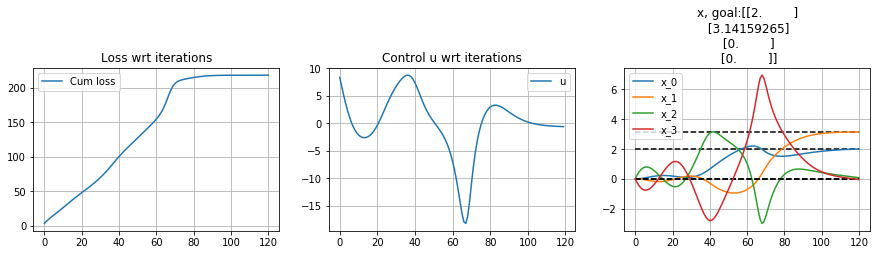

In [1073]:

Q = 1*np.eye(4)
Q[1][1] = 10
Q[0][0] = 10

Qf = 20*Q
#Qf[0][0] = 11

R = 1*np.eye(1)
CP_env.solve_iLQR(x0=x0,
                  xf=xf,
                  N=N,
                  n_traj=200,
                 alpha_init=1,
                 crit_alpha=1,
                 Q=Q,
                 Qf=Qf)

plt.figure(figsize=(15,3))
plt.subplot(131)
CP_env.ilqr.plot_loss()
plt.subplot(132)
CP_env.ilqr.plot_u()
plt.subplot(133)
CP_env.ilqr.plot_x()

In [911]:
CP_env.ilqr.rho_reg

0

In [1075]:
f"{np.diag(Q)}"

'[10. 10.  1.  1.]'

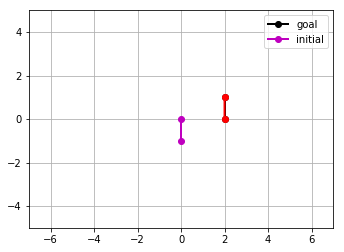

In [1077]:
CP_env.create_animation(name=f"swingup_Q-{np.diag(Q)}_N_{N}_dt_{dt}")

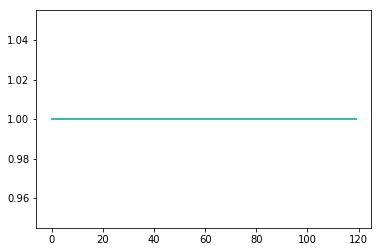

In [691]:
all_cnd = CP_env.ilqr.all_cond_nb 
for i in range(len(all_cnd)):
    plt.plot(all_cnd[i], label=f"{i}")


In [668]:
CP_env.ilqr.alpha

0.0009765625

In [640]:
rollout_hist = CP_env.ilqr.rollout_hist
n_rol = len(rollout_hist)

0
3
6
9
12
15
18


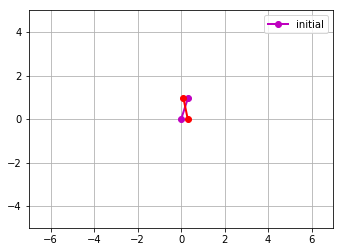

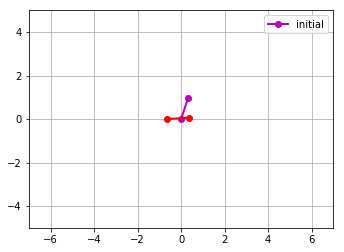

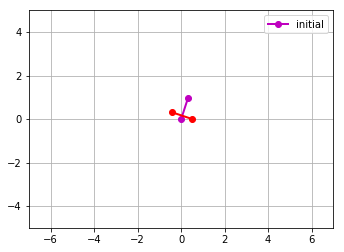

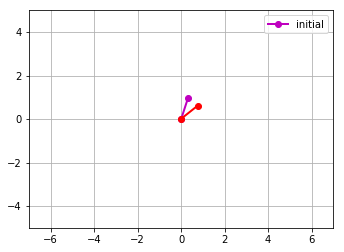

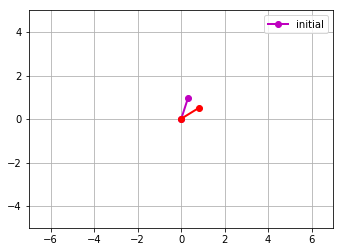

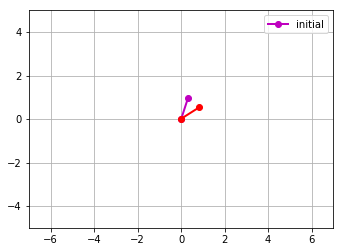

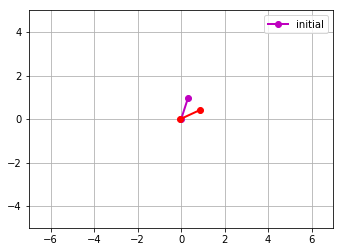

In [642]:
for i in range(n_rol):
    if i%3==0 and i <20:
        print(i)
        CP_env.create_animation(name=f"cart_{i}", x=rollout_hist[i])

### Cartpole Debug

In [990]:
dt = 0.03
N = 100
#qf=1
m = M = l = 1

CP_env = DebugCartPoleEnv(dt=dt,
                      m=m,
                      M=M,
                      l=l)


x0 = np.array([[0],[0*np.pi], [0], [0]])

xf =  np.array([[0], [1.0*np.pi], [0], [0]])

Initial cost: x0, u= 0, J =  0.29608813203268075
Last cost: x0, u= 0, J =  98.69604401089357
**** 0-th Trajectory 
**** 10-th Trajectory 
**** 20-th Trajectory 
**** 30-th Trajectory 
**** 40-th Trajectory 
**** 50-th Trajectory 
**** 60-th Trajectory 
**** 70-th Trajectory 
**** 80-th Trajectory 
**** 90-th Trajectory 
**** 100-th Trajectory 
**** 110-th Trajectory 
**** 120-th Trajectory 
**** 130-th Trajectory 
**** 140-th Trajectory 
**** 150-th Trajectory 
**** 160-th Trajectory 
**** 170-th Trajectory 
**** 180-th Trajectory 
**** 190-th Trajectory 
Last Loss:  46.846687480835875


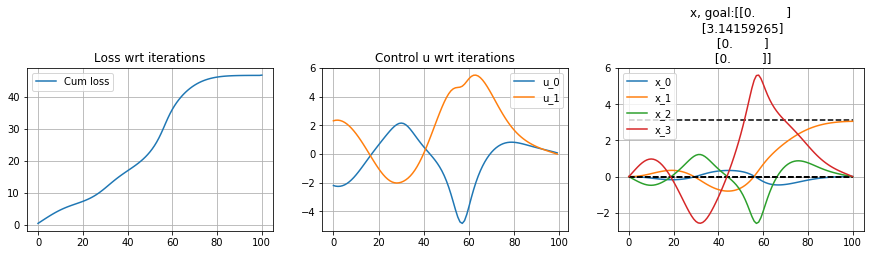

In [993]:

Q = 2*np.eye(4)
Q[1][1] = 2
Q[0][0] = 2
Q[3][3] = 1

Qf = 10*Q
#Qf[0][0] = 11

R = 1*np.eye(2)
CP_env.solve_iLQR(x0=x0,
                  xf=xf,
                  N=N,
                  n_traj=200,
                 alpha_init=1,
                 crit_alpha=10,
                 Q=Q,
                 Qf=Qf,
                 R=R)

plt.figure(figsize=(15,3))
plt.subplot(131)
CP_env.ilqr.plot_loss()
plt.subplot(132)
CP_env.ilqr.plot_u()
plt.subplot(133)
CP_env.ilqr.plot_x()

In [955]:
CP_env.ilqr.alpha

1

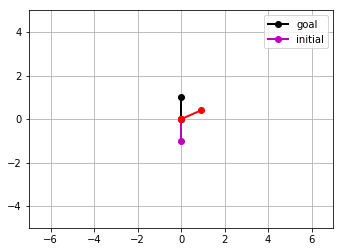

In [975]:
CP_env.create_animation(name="cart")

In [985]:
rollout_hist = CP_env.ilqr.rollout_hist
n_rol = len(rollout_hist)
print(n_rol)

67


0
15
30
45
60


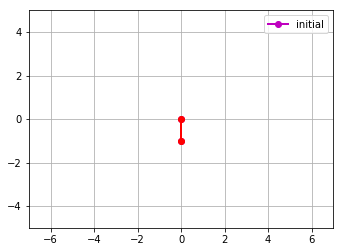

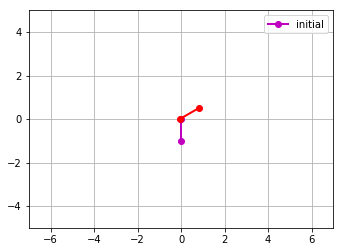

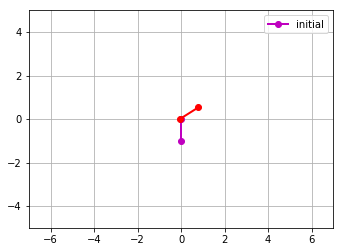

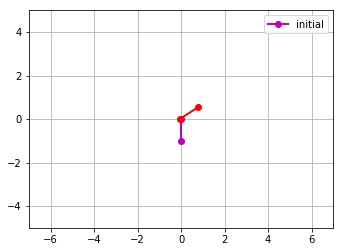

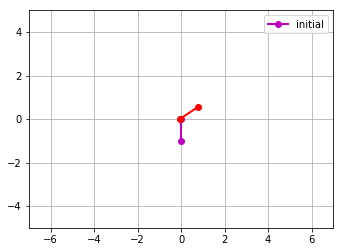

In [986]:
for i in range(n_rol):
    if i%15==0 :#and i <20:
        print(i)
        CP_env.create_animation(name=f"cart_{i}", x=rollout_hist[i])

## Unicycle

In [1548]:
class UnicycleDynamics(Dynamics):
    def __init__(self, dt):
        """
        state (x,y,v,theta)
        control (v, theta)
        theta = 0 : towards x > 0
        """
        self.dt = dt
        super().__init__(state_dim=4, u_dim=2)
        
    
    
    def f(self, x, u):
        v = x[2][0]
        theta = x[3][0]
        
        dxdt = np.array([[v*np.cos(theta)], [v*np.sin(theta)], [0], [0]]) \
               + np.array([[0], [0], [u[0][0]], [u[1][0]]])
        #dxdt = np.zeros((self.state_dim, self.u_dim))
        #dxdt[2][0] = u[0][0]
        #dxdt[3][1] = u[1][0]
        return x + dxdt*self.dt
    

In [1555]:
class UnicycleEnv(Environment):
    def __init__(self, dt):
        super().__init__(dt, state_dim=4, u_dim=2)
        self.dynamics = UnicycleDynamics(self.dt)
    
    def position(self,x):
        position_x = [x[0][0]]
        position_y = [x[2][0]]
        return (position_x, position_y)
        

In [1556]:
dt = 0.1
N = 100


x0 = np.array([[4], #x
               [3], #y
               [0], #v
               [0]])#theta
xf = np.array([[0], 
               [0], 
               [0], 
               [0]])
print(x0, "x0")
print(xf, "xf")


uni_env = UnicycleEnv(dt=dt)

[[4]
 [3]
 [0]
 [0]] x0
[[0]
 [0]
 [0]
 [0]] xf


Initial cost: x0, u= 0, J =  1.25
Last cost: x0, u= 0, J =  12.5
**** 0-th Trajectory 
**** 5-th Trajectory 
**** 10-th Trajectory 
**** 15-th Trajectory 
Last Loss:  24.3278210629881


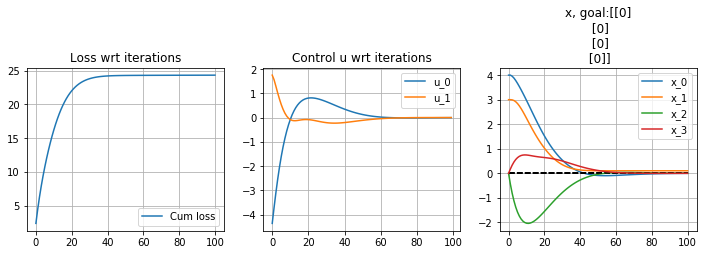

In [1568]:
uni_env.solve_iLQR(x0=x0,
                  xf=xf,
                  N=N,
                  n_traj=20,
                alpha_init=1,
                 crit_alpha=10)


plt.figure(figsize=(12,3))
plt.subplot(131)
uni_env.ilqr.plot_loss()
plt.subplot(132)
uni_env.ilqr.plot_u()
plt.subplot(133)
uni_env.ilqr.plot_x()

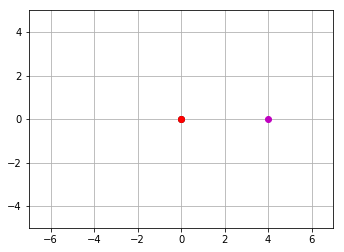

In [1558]:
uni_env.create_animation(name="unicycle")

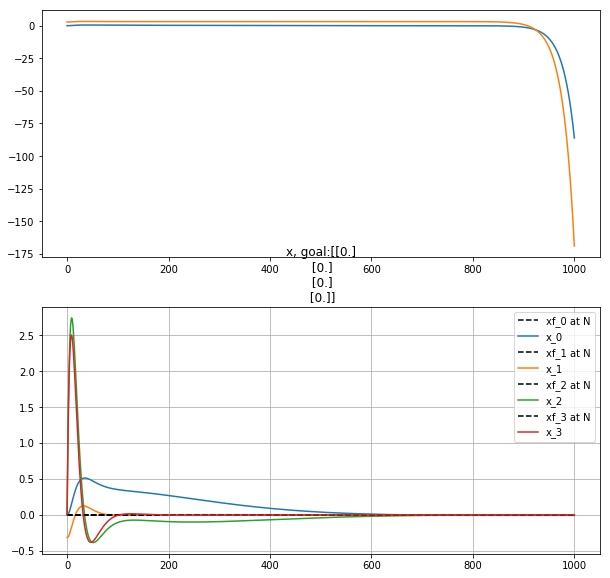

In [66]:
x_h = [x0[0]]
th_h = [x0[1]]
cur_x = x0
for i in range(N):
    cur_xbar = cur_x - CartPoleEnv.x_lin
    cur_xbar =  CartPoleEnv.linear_dynamics.next_state(cur_xbar , u_sequence[i])
    cur_x = CartPoleEnv.x_lin + cur_xbar
    x_h.append(cur_x[0])
    th_h.append(cur_x[1])
   # print(cur_x- CartPoleEnv.clqr.x[i])
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(x_h)
plt.plot(th_h)
plt.subplot(212)
CartPoleEnv.clqr.plot_x()

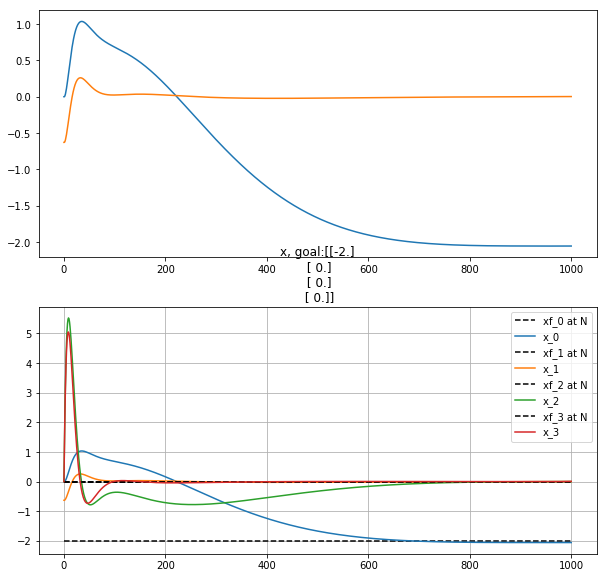

In [107]:
x_h = [x0[0]]
th_h = [x0[1]-np.pi]
cur_x = x0 - CartPoleEnv.x_lin
for i in range(N):
    cur_x = CartPoleEnv.linear_dynamics.next_state(cur_x, u_sequence[i])
    x_h.append(cur_x[0])
    th_h.append(cur_x[1])
   # print(cur_x- CartPoleEnv.clqr.x[i])
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(x_h)
plt.plot(th_h)
plt.subplot(212)
CartPoleEnv.clqr.plot_x()

In [ ]:

    
class OldCartPole:
    def compute_linear_dynamics(self,):
        """
        Compute linear dynamics, linearizing around the fixed, unstable pair
        (x_lin = [0, \pi, 0, 0], u_lin = 0)
        
        A and B are such that (x_{k+1}-x_lin) = A(x_k-x_lin) + B(u_k-u_lin)
        """
        self.x_lin = np.array([[0],[np.pi],[0],[0]])
        self.u_lin = 0
        A = np.eye(self.state_dim) + self.dt* np.array([[0,0,1,0],
                                                        [0,0,0,1],
                                                [0, self.m*self.g/self.M, 0,0],
                              [0, (self.m+self.M)*self.g/(self.l*self.M), 0,0]])
        
        B = self.dt* np.array([[0.],
                                [0.],
                              [1/self.M],
                              [1/(self.l*self.M)]])
        return A,B
    
    def solve_LQR(self, Q, R, goal, N, x0):
        xbar_0 = x0 - self.x_lin
        xbar_f = goal - self.x_lin
        
        cost = LQRCost(Q=Q, R=R, goal=xbar_f, N=N)
        LP = LinearProblem(dynamics=self.linear_dynamics,
                          cost=cost,
                          dt=self.dt,
                          x0=xbar_0)
       
        self.clqr = LQR(LP)
        self.clqr.solve()
        u_sequence = [ubar + self.u_lin for ubar in self.clqr.u]
        return u_sequence
    
    


    
    def next_state(self, x, u):
        """
        Compute next state without linear approx dynamics 
        x = x.flatten()
        def dstate_dt_u(state, t):
            dydx = self.dstate_dt(state, u)
            return dydx
        next_x = integrate.odeint(dstate_dt_u, x, [0, self.dt])[1]
        return next_x.reshape(self.state_dim,1)
        """
        xbar = x - self.x_lin
        xbar_next = self.linear_dynamics.next_state(xbar,u)
        return xbar_next + self.x_lin
    